In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sb
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from scipy import interp

from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from mpl_toolkits.mplot3d import axes3d
from pylab import rcParams
#%matplotlib notebook

In [2]:
f = h5py.File('logs/predictions_default.h5', 'r')

labels = np.array(f['labels'][:]).astype(int)
probs = np.array(f['probs']).astype(float)
mc_cosmics = np.array(f['rec.mc.cosmic']).astype(float)
vtx_stop = np.array(f['vtx_stop']).astype(float)
data = {'muon': list(labels).count(13), 'electron': list(labels).count(11), 'piminus': list(labels).count(-211)}
print(data)

{'muon': 80, 'electron': 80, 'piminus': 80}


In [3]:
labels[labels == 13] = 0
labels[labels == 11] = 1
labels[labels == -211] = 2

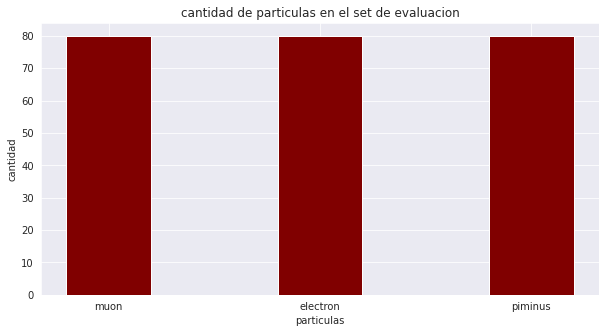

In [4]:

part = list(data.keys())
cant = list(data.values())

fig = plt.figure(figsize=(10, 5))

# creating the bar plot
plt.bar(part, cant, color='maroon', width=0.4)

plt.xlabel("particulas")
plt.ylabel("cantidad")
plt.title("cantidad de particulas en el set de evaluacion")
plt.savefig("./plots/dist_eval.png")


In [5]:
clases = ['muon', 'electron', 'piminus']
y_preds = np.argmax(probs, axis=1)

              precision    recall  f1-score   support

        muon       0.36      0.62      0.45        80
    electron       0.37      0.23      0.28        80
     piminus       0.37      0.24      0.29        80

    accuracy                           0.36       240
   macro avg       0.37      0.36      0.34       240
weighted avg       0.37      0.36      0.34       240



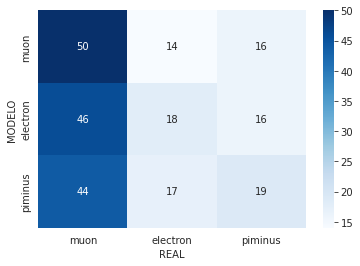

In [6]:

CM = confusion_matrix(labels, y_preds)
print(classification_report(labels, y_preds, target_names=['muon', 'electron', 'piminus']))
#print(CM)
dfmat = pd.DataFrame(CM, index=clases, columns=clases)
grafica = sb.heatmap(dfmat, cmap='Blues', annot=True, fmt='g')
grafica.set(xlabel='REAL', ylabel='MODELO')
plt.savefig('plots/confucion.png')
plt.show()

In [7]:

predicciones = {'pdm': [], 'pde': [], 'pdp': [], 'label_true': [], 'predic': [], 'calificacion': [], 'p.pz': [],
                'p.E': [], 'nhitslc': [], 'vtx.x': [], 'vtx.y': [], 'vtx.z': [], 'stop.x': [], 'stop.y': [],
                'stop.z': [], 'euclidean': []}

for y_true, ypred, prob, mc_cosmic, vtxstop in zip(labels, y_preds, probs, mc_cosmics, vtx_stop):

    #predicciones['nombre'].append(fname)
    predicciones['pdm'].append(float(prob[0]))
    predicciones['pde'].append(float(prob[1]))
    predicciones['pdp'].append(float(prob[2]))
    predicciones['label_true'].append(clases[y_true[0]])

    predicciones['predic'].append(clases[ypred])
    if (clases[y_true[0]] == clases[ypred]):
        predicciones['calificacion'].append('T' + str(clases[y_true[0]]))
    else:
        predicciones['calificacion'].append('F' + str(clases[ypred]))
    predicciones['p.pz'].append(float(mc_cosmic[0]))
    predicciones['p.E'].append(float(mc_cosmic[1]))
    predicciones['nhitslc'].append(float(mc_cosmic[2]))
    predicciones['vtx.x'].append(float(vtxstop[0]))
    predicciones['vtx.y'].append(float(vtxstop[1]))
    predicciones['vtx.z'].append(float(vtxstop[2]))
    predicciones['stop.x'].append(float(vtxstop[3]))
    predicciones['stop.y'].append(float(vtxstop[4]))
    predicciones['stop.z'].append(float(vtxstop[5]))
    predicciones['euclidean'].append(float(np.sqrt(np.sum(
        np.square(np.array((vtxstop[0], vtxstop[1], vtxstop[2])) - np.array((vtxstop[3], vtxstop[4], vtxstop[5],)))))))
dfpred = pd.DataFrame(data=predicciones)
dfpred=dfpred[dfpred['stop.z']<1200]
dfpred=dfpred[dfpred['vtx.z']<700]

In [8]:
# Binarize the output
y_test = label_binarize(dfpred['label_true'], classes=clases)
n_classes = y_test.shape[1]
y_score = dfpred[["pdm", "pde", "pdp"]].values

In [9]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/tmp/ipykernel_38244/3372414517.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


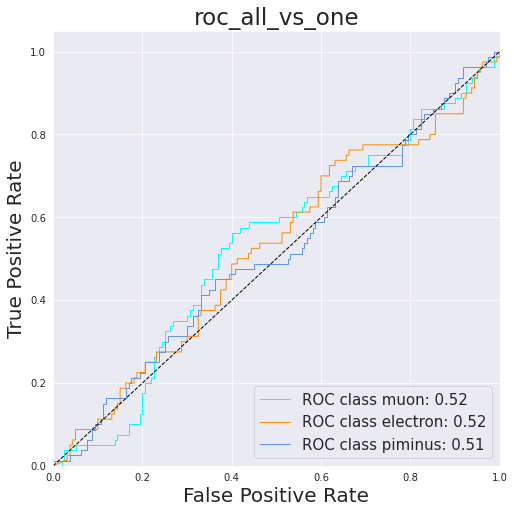

In [10]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC class ' + clases[i] + ': ' + str(roc_auc[i])[
                                                                                        0:4])  #ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('roc_all_vs_one', fontsize=23)
plt.legend(loc="lower right", prop={'size': 15})
plt.savefig("plots/roc_all_vs_one.jpg")
plt.show()

In [11]:
dfpred.to_excel('predicciones.xlsx')

In [12]:
calificaciones = list(dfpred['calificacion'].drop_duplicates())
colors = ["red", "green", "blue", "yellow", "pink", "orange"]

In [13]:
from pylab import rcParams

rcParams['figure.figsize'] = 16, 9

In [14]:
def compute_profile(x, y, nbin=(100, 100)):
    # use of the 2d hist by numpy to avoid plotting
    h, xe, ye = np.histogram2d(x, y, nbin)

    # bin width
    xbinw = xe[1] - xe[0]

    # getting the mean and RMS values of each vertical slice of the 2D distribution
    # also the x valuse should be recomputed because of the possibility of empty slices
    x_array = []
    x_slice_mean = []
    x_slice_rms = []
    for i in range(xe.size - 1):
        yvals = y[(x > xe[i]) & (x <= xe[i + 1])]
        if yvals.size > 0:  # do not fill the quanties for empty slices
            x_array.append(xe[i] + xbinw / 2)
            x_slice_mean.append(yvals.mean())
            x_slice_rms.append(yvals.std())
    x_array = np.array(x_array)
    x_slice_mean = np.array(x_slice_mean)
    x_slice_rms = np.array(x_slice_rms)

    return x_array, x_slice_mean, x_slice_rms

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

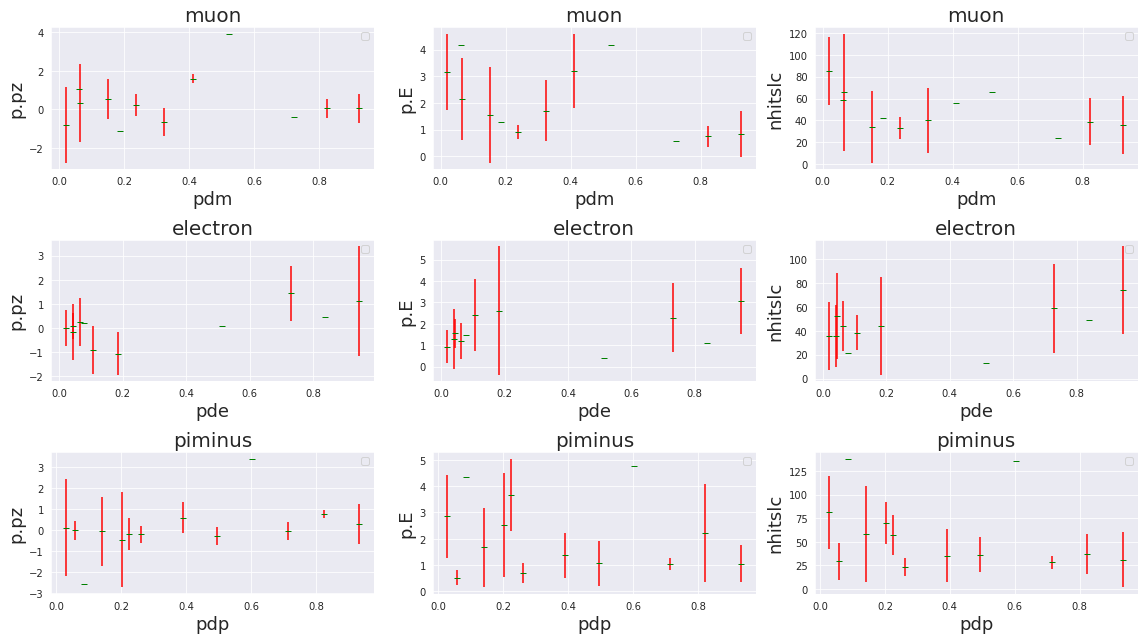

In [15]:
from pylab import rcParams

rcParams['figure.figsize'] = 16, 9
fig, axes = plt.subplots(nrows=3, ncols=3)
colors = ["red", "green", "blue", "yellow", "pink", "orange"]
for label, prob, filas in zip(['muon', 'electron', 'piminus'], ['pdm', 'pde', 'pdp'], axes):
    for prop, ax in zip(['p.pz', 'p.E', 'nhitslc'], filas):
        for n, calificacion in enumerate(calificaciones):

            df = dfpred[dfpred['calificacion'] == calificacion]
            df = df[df['label_true'] == label]
            if (len(df) == 0): continue
            p_x, p_mean, p_rms = compute_profile(df[prob], df[prop], (5, 5))

            #ax.scatter(df[prob], df[prop], c=colors[n], label=calificacion)
            ax.errorbar(p_x, p_mean, p_rms, fmt='_', ecolor='r', color='g')
            #plt.errorbar(p_x, p_mean, p_rms,fmt='_', ecolor='r', c=colors[n], label=calificacion)
            ax.set_title(label, size=20)
            ax.set_ylabel(prop, size=18)
            ax.set_xlabel(prob, size=18)
            ax.legend()
            ax.grid(True)

        #plt.xlabel(prob, size=18)
        #plt.ylabel(prop, size=18)
        #plt.title(label, size=20)
fig.tight_layout()
plt.savefig('plots/profile_score_vs_prop.jpg')
plt.show()

/tmp/ipykernel_38244/2950938110.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')
/tmp/ipykernel_38244/2950938110.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')
/tmp/ipykernel_38244/2950938110.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')
/tmp/ipykernel_38244/2950938110.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call 

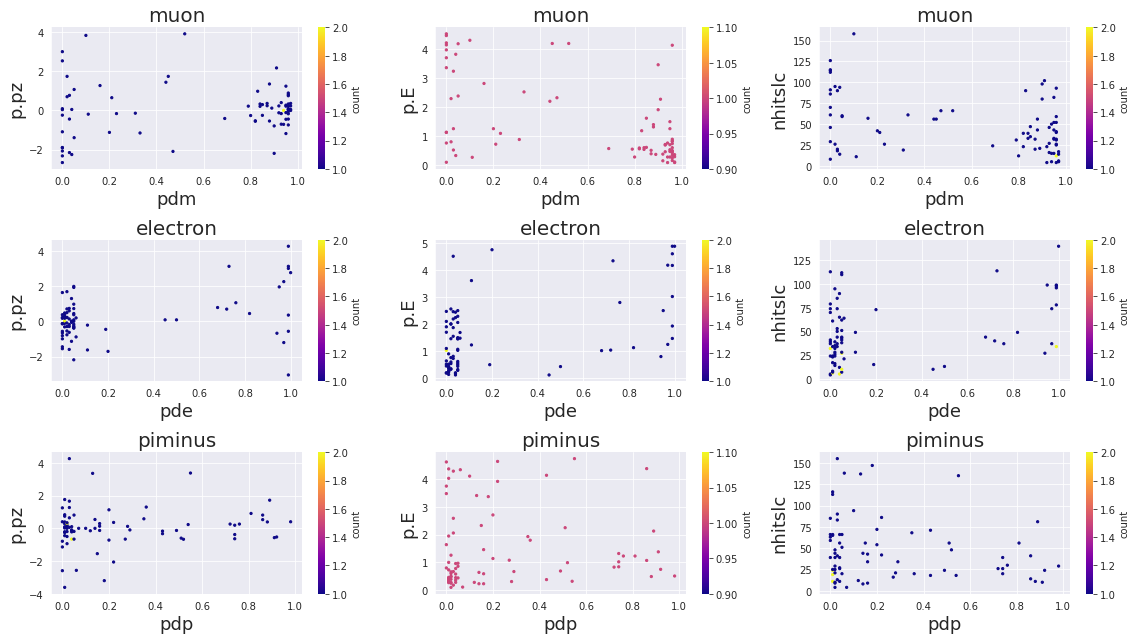

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=3)
colors = ["red", "green", "blue", "yellow", "pink", "orange"]
for label, prob, filas in zip(['muon', 'electron', 'piminus'], ['pdm', 'pde', 'pdp'], axes):
    for prop, ax in zip(['p.pz', 'p.E', 'nhitslc'], filas):
        df = (dfpred[dfpred['label_true'] == label])[[prop, prob]]
        df = np.trunc(100 * df) / 100
        df = df.groupby([prob, prop]).size().reset_index(name='counts')
        colors = df['counts']
        p = ax.scatter(df[prob], df[prop], s=5, vmin=1, vmax=colors.max(), c=colors, cmap='plasma')

        ax.set_title(label, size=20)
        ax.set_ylabel(prop, size=18)
        ax.set_xlabel(prob, size=18)

        ax.grid(True)
        cb = fig.colorbar(p, ax=ax, label='count')
        cb.outline.set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.savefig('plots/score_vs_prop.jpg')
plt.show()

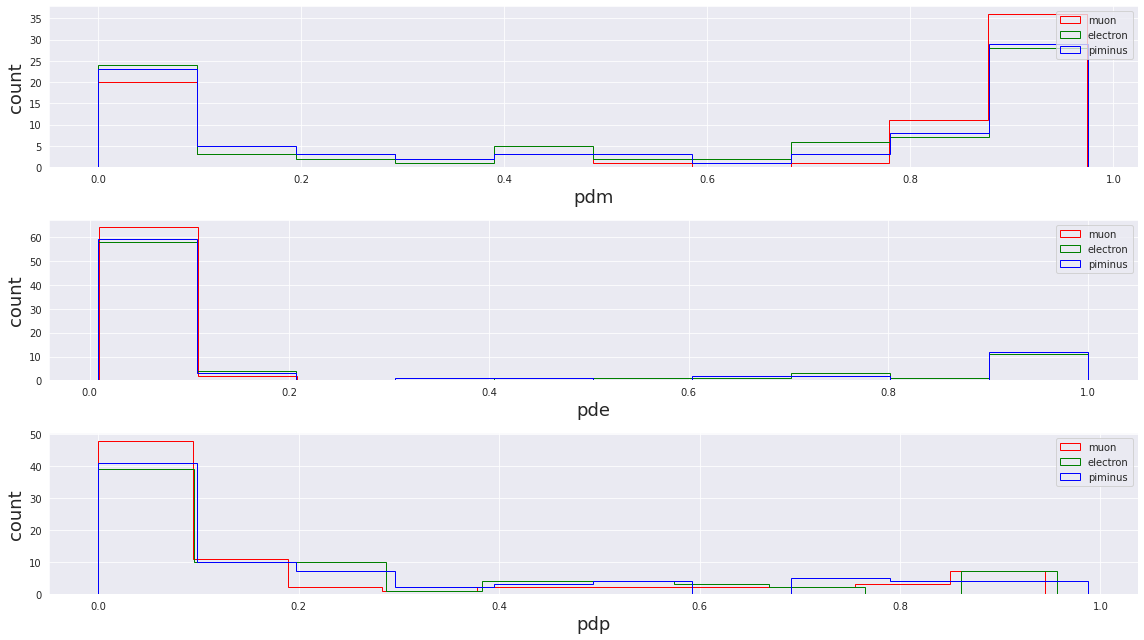

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=1)
for prob, ax in zip(['pdm', 'pde', 'pdp'], axes):
    for label, color in zip(list(dfpred['label_true'].drop_duplicates()), ["red", "green", "blue"]):
        ax.hist((dfpred[dfpred['label_true'] == label])[prob], 10, histtype='step', stacked=True, fill=False,
                color=color, label=label)

        ax.legend()
        ax.set_xlabel(prob, size=18)
        ax.set_ylabel('count', size=18)
fig.tight_layout()
plt.savefig('plots/dist_score_label.jpg')
plt.show()

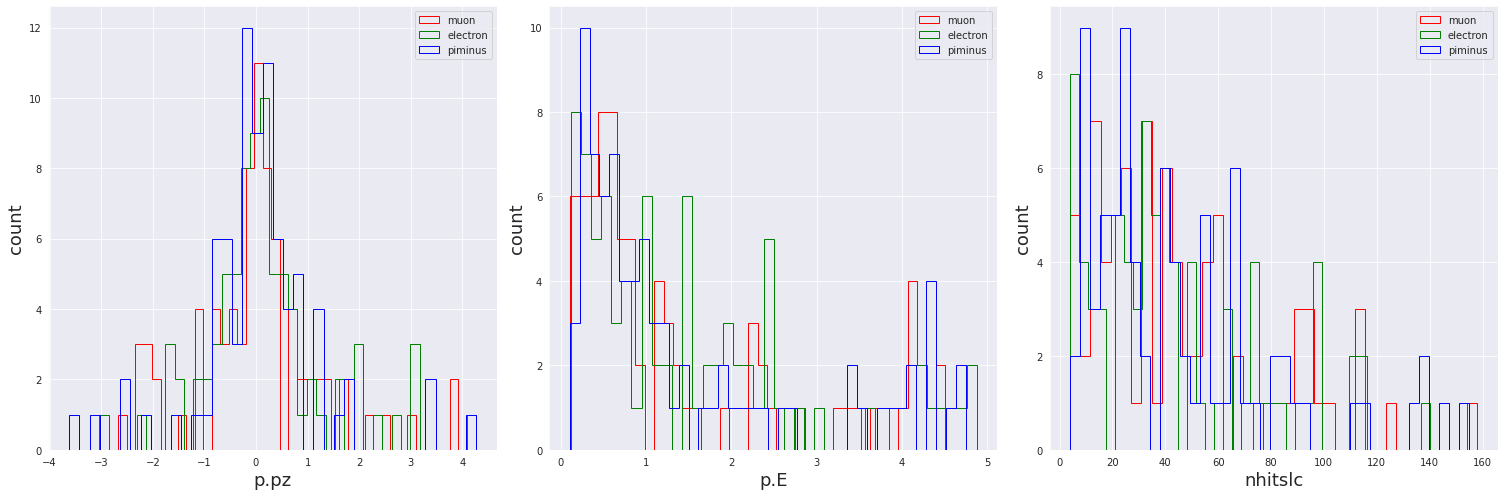

In [18]:


rcParams['figure.figsize'] = 21, 7
fig, axes = plt.subplots(nrows=1, ncols=3)
colors = ["red", "green", "blue", "yellow", "pink", "orange"]
for prop, ax in zip(['p.pz', 'p.E', 'nhitslc'], axes):
    for label, color in zip(['muon', 'electron', 'piminus'], ["red", "green", "blue"]):
        ax.hist((dfpred[dfpred['label_true'] == label])[prop], 40, histtype='step', stacked=True, fill=False,
                color=color, label=label)
        #ax.set_title(label, size=20)
        ax.set_ylabel('count', size=18)
        ax.set_xlabel(prop, size=18)
        ax.legend()
        ax.grid(True)

fig.tight_layout()
plt.savefig('plots/dist_prop_label.jpg')
plt.show()

/tmp/ipykernel_38244/3558964111.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')
/tmp/ipykernel_38244/3558964111.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')
/tmp/ipykernel_38244/3558964111.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')


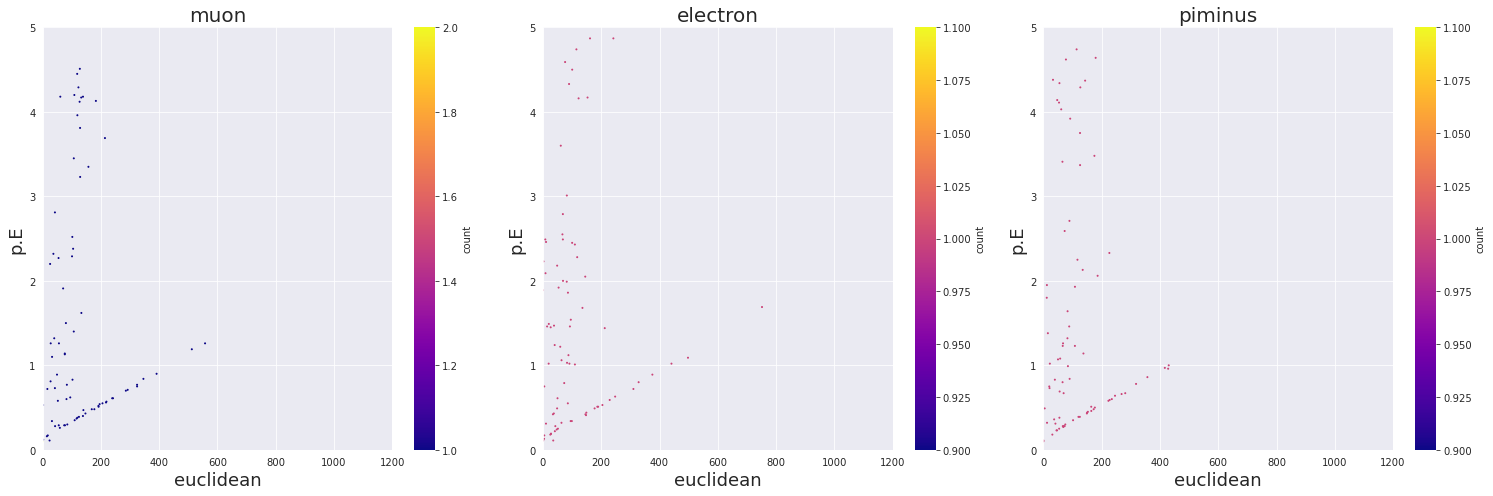

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3)
for label, prob, ax in zip(['muon', 'electron', 'piminus'], ['pdm', 'pde', 'pdp'], axes):
    df = (dfpred[dfpred['label_true'] == label])[['euclidean', 'p.E']]
    df = np.trunc(100 * df) / 100
    df = df.groupby(['euclidean', 'p.E']).size().reset_index(name='counts')
    colors = df['counts']
    p = ax.scatter(df['euclidean'], df['p.E'], s=1, vmin=1, vmax=colors.max(), c=colors, cmap='plasma')

    ax.set_title(label, size=20)
    ax.set_ylabel('p.E', size=18)
    ax.set_xlabel('euclidean', size=18)
    ax.set_xlim(0,1200)
    ax.set_ylim(0, 5)
    ax.grid(True)
    cb = fig.colorbar(p, ax=ax, label='count')
    cb.outline.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.savefig('plots/euclidean_vs_prop.jpg')
plt.show()

/tmp/ipykernel_38244/3710367823.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')
/tmp/ipykernel_38244/3710367823.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')
/tmp/ipykernel_38244/3710367823.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(p, ax=ax, label='count')


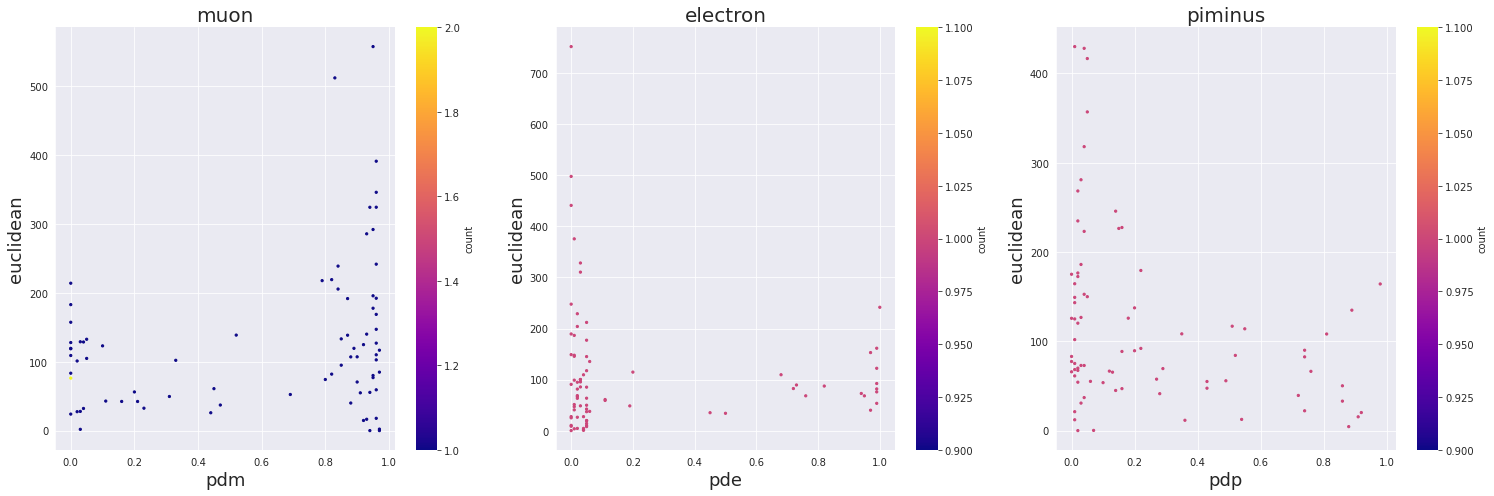

In [20]:
rcParams['figure.figsize'] = 21, 7
fig, axes = plt.subplots(nrows=1, ncols=3)
for label, prob, ax in zip(['muon', 'electron', 'piminus'], ['pdm', 'pde', 'pdp'], axes):
    df = (dfpred[dfpred['label_true'] == label])[[prob, 'euclidean']]
    df = np.trunc(100 * df) / 100
    df = df.groupby([prob, 'euclidean']).size().reset_index(name='counts')
    colors = df['counts']
    p = ax.scatter(df[prob], df['euclidean'], s=5, vmin=1, vmax=colors.max(), c=colors, cmap='plasma')

    ax.set_title(label, size=20)
    ax.set_ylabel('euclidean', size=18)
    ax.set_xlabel(prob, size=18)

    ax.grid(True)
    cb = fig.colorbar(p, ax=ax, label='count')
    cb.outline.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.savefig('plots/euclidean_vs_score.jpg')
plt.show()

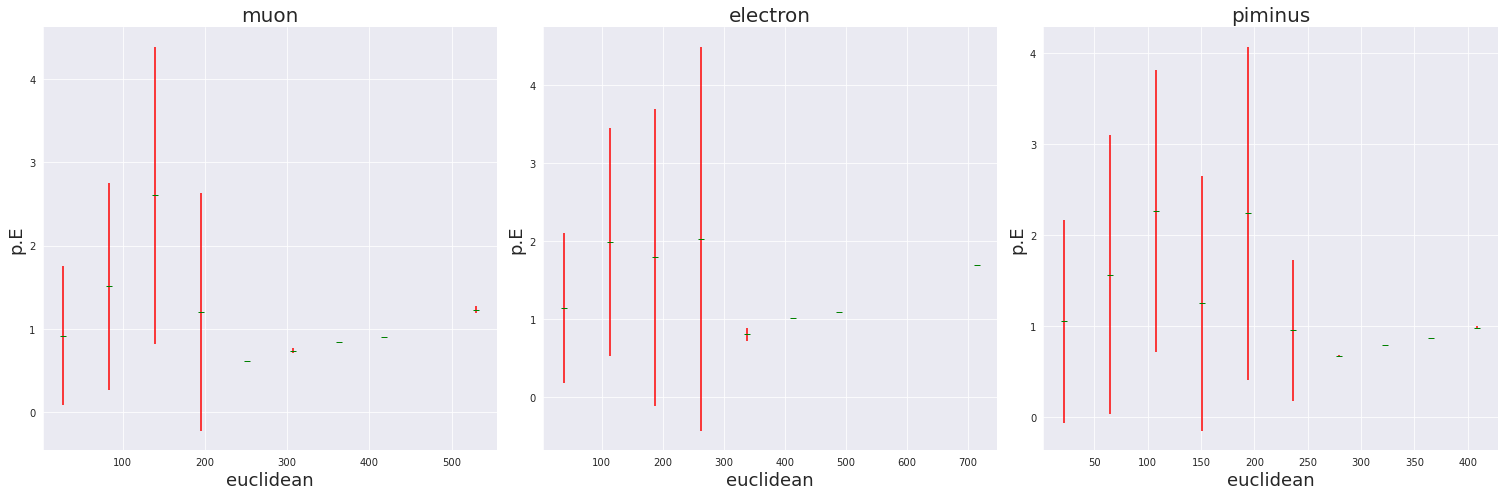

In [21]:
rcParams['figure.figsize'] = 21, 7
fig, axes = plt.subplots(nrows=1, ncols=3)
for label, prob, ax in zip(['muon', 'electron', 'piminus'], ['pdm', 'pde', 'pdp'], axes):
    df = (dfpred[dfpred['label_true'] == label])[['euclidean', 'p.E']]
    p_x, p_mean, p_rms = compute_profile(df['euclidean'], df['p.E'], (10, 10))

    ax.errorbar(p_x, p_mean, p_rms, fmt='_', ecolor='r', color='g')
    ax.set_title(label, size=20)
    ax.set_ylabel('p.E', size=18)
    ax.set_xlabel('euclidean', size=18)

    ax.grid(True)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.savefig('plots/profile_euclidean_vs_prop.jpg')
plt.show()

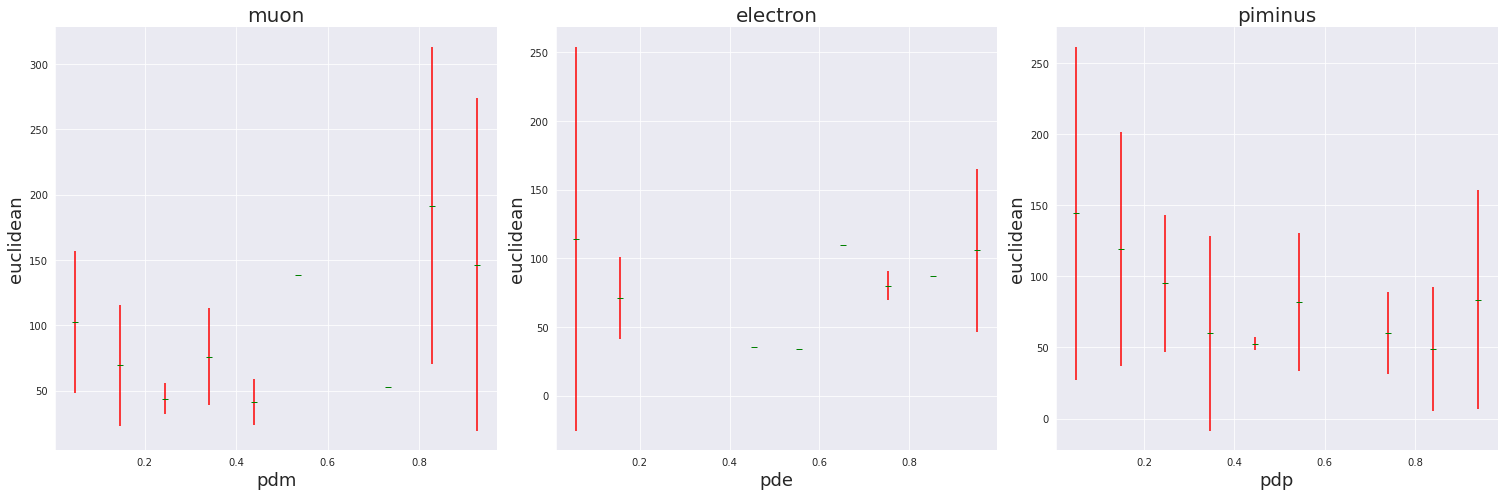

In [22]:
rcParams['figure.figsize'] = 21, 7
fig, axes = plt.subplots(nrows=1, ncols=3)
for label, prob, ax in zip(['muon', 'electron', 'piminus'], ['pdm', 'pde', 'pdp'], axes):
    df = (dfpred[dfpred['label_true'] == label])[[prob, 'euclidean']]

    p_x, p_mean, p_rms = compute_profile(df[prob], df['euclidean'], (10, 10))

    ax.errorbar(p_x, p_mean, p_rms, fmt='_', ecolor='r', color='g')

    ax.set_title(label, size=20)
    ax.set_ylabel('euclidean', size=18)
    ax.set_xlabel(prob, size=18)

    ax.grid(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.savefig('plots/profile_score_vs_score.jpg')
plt.show()

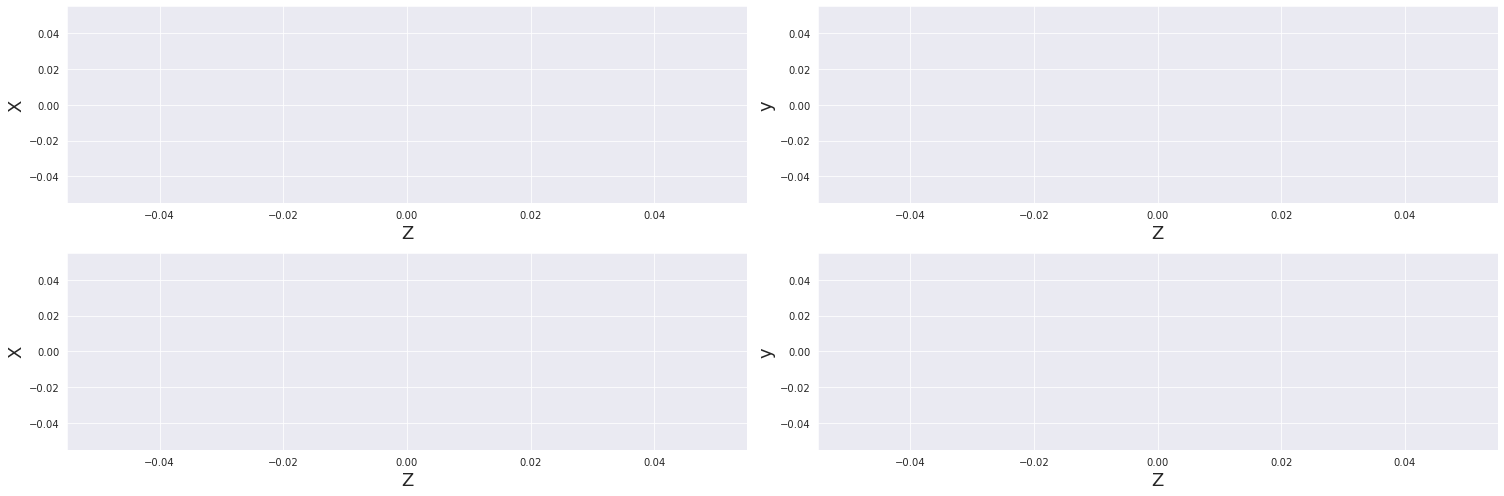

In [23]:
select_m = dfpred
select_m=select_m[select_m['p.E']>1.5]
select_m=select_m[select_m['pdm']>0.6]
select_m=select_m[select_m['pdm']<0.8]

rcParams['figure.figsize'] = 21, 7
fig, ((vtx_xz, vtx_yz), (stop_xz, stop_yz)) = plt.subplots(nrows=2, ncols=2)
df = (select_m[select_m['label_true'] == 'muon'])

vtx_xz.scatter(df['vtx.z'], df['vtx.x'], s=5, vmin=1)
vtx_xz.set_ylabel('X', size=18)
vtx_xz.set_xlabel('Z', size=18)
vtx_xz.grid(True)

vtx_yz.scatter(df['vtx.z'], df['vtx.y'], s=5, vmin=1)
vtx_yz.set_ylabel('y', size=18)
vtx_yz.set_xlabel('Z', size=18)

vtx_yz.grid(True)

stop_xz.scatter(df['stop.z'], df['stop.x'], s=5, vmin=1)
stop_xz.set_ylabel('X', size=18)
stop_xz.set_xlabel('Z', size=18)
stop_xz.grid(True)

stop_yz.scatter(df['stop.z'], df['stop.y'], s=5, vmin=1)
stop_yz.set_ylabel('y', size=18)
stop_yz.set_xlabel('Z', size=18)

stop_yz.grid(True)

fig.tight_layout()
plt.show()